<a href="https://colab.research.google.com/github/kiogora-nk/AI-Week-7/blob/main/week7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

compas-scores-two-years.csv already exists.
=== ORIGINAL TRAINING DATASET BIAS ===
Disparate Impact: 0.8440
Mean Difference: -0.0944

=== METRICS AFTER REWEIGHING ===
Accuracy: 0.6575
Statistical Parity Difference: 0.0158
Equal Opportunity Difference: 0.0798
False Positive Rate Difference: 0.0006
False Negative Rate Difference: -0.0798


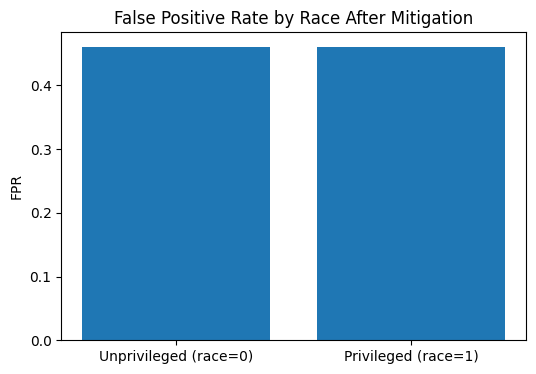

In [6]:
# ===========================
# 1. IMPORT LIBRARIES
# ===========================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

!pip install aif360
from aif360.datasets import CompasDataset
from aif360.metrics import BinaryLabelDatasetMetric, ClassificationMetric
from aif360.algorithms.preprocessing import Reweighing

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from aif360.datasets import BinaryLabelDataset

# ===========================
# 2. LOAD COMPAS DATA
# ===========================

# Define the path where the dataset should be stored
data_dir = '/usr/local/lib/python3.12/dist-packages/aif360/data/raw/compas'
data_file = 'compas-scores-two-years.csv'
full_path = os.path.join(data_dir, data_file)

# Create the directory if it doesn't exist
os.makedirs(data_dir, exist_ok=True)

# Download the file if it doesn't exist
if not os.path.exists(full_path):
    print(f"Downloading {data_file}...")
    !wget -O {full_path} https://raw.githubusercontent.com/propublica/compas-analysis/master/compas-scores-two-years.csv
    print("Download complete.")
else:
    print(f"{data_file} already exists.")

dataset = CompasDataset(
    protected_attribute_names=['race'],
    privileged_classes=[['Caucasian']],
    features_to_drop=['sex', 'age', 'c_charge_degree']
)

# Split train/test
dataset_train, dataset_test = dataset.split([0.7], shuffle=True)

# Protected/unprivileged groups
priv = [{'race': 1}]
unpriv = [{'race': 0}]

# ===========================
# 3. ORIGINAL BIAS METRICS
# ===========================
metric_orig_train = BinaryLabelDatasetMetric(
    dataset_train,
    unprivileged_groups=unpriv,
    privileged_groups=priv
)

print("=== ORIGINAL TRAINING DATASET BIAS ===")
print(f"Disparate Impact: {metric_orig_train.disparate_impact():.4f}")
print(f"Mean Difference: {metric_orig_train.mean_difference():.4f}")

# ===========================
# 4. APPLY REWEIGHING
# ===========================
RW = Reweighing(unprivileged_groups=unpriv, privileged_groups=priv)
dataset_transf_train = RW.fit_transform(dataset_train)

# ===========================
# 5. TRAIN LOGISTIC REGRESSION
# ===========================
model = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(max_iter=1000))
])

X_train = dataset_transf_train.features
y_train = dataset_transf_train.labels.ravel()
sample_weights = dataset_transf_train.instance_weights

model.fit(X_train, y_train, clf__sample_weight=sample_weights)

# ===========================
# 6. PREDICT ON TEST SET
# ===========================
X_test = dataset_test.features
y_test = dataset_test.labels.ravel()

y_pred = model.predict(X_test)

dataset_test_pred = dataset_test.copy()
dataset_test_pred.labels = y_pred.reshape(-1, 1)

# ===========================
# 7. FAIRNESS METRICS AFTER MITIGATION
# ===========================
metric_transf_test = ClassificationMetric(
    dataset_test,
    dataset_test_pred,
    unprivileged_groups=unpriv,
    privileged_groups=priv
)

print("\n=== METRICS AFTER REWEIGHING ===")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"Statistical Parity Difference: {metric_transf_test.statistical_parity_difference():.4f}")
print(f"Equal Opportunity Difference: {metric_transf_test.equal_opportunity_difference():.4f}")
print(f"False Positive Rate Difference: {metric_transf_test.false_positive_rate_difference():.4f}")
print(f"False Negative Rate Difference: {metric_transf_test.false_negative_rate_difference():.4f}")

# ===========================
# 8. VISUALIZATION
# ===========================
# False Positive Rate comparison
groups = ['Unprivileged (race=0)', 'Privileged (race=1)']
fpr_values = [
    metric_transf_test.false_positive_rate(privileged=False),
    metric_transf_test.false_positive_rate(privileged=True)
]

plt.figure(figsize=(6, 4))
plt.bar(groups, fpr_values)
plt.title("False Positive Rate by Race After Mitigation")
plt.ylabel("FPR")
plt.show()
